In [1]:
! pip install langchain transformers scikit-learn pandas requests torch


  Using cached torch-2.2.2-cp310-none-macosx_10_9_x86_64.whl.metadata (25 kB)
  Using cached filelock-3.15.4-py3-none-any.whl.metadata (2.9 kB)
  Using cached safetensors-0.4.3-cp310-cp310-macosx_10_12_x86_64.whl.metadata (3.8 kB)
  Using cached tokenizers-0.19.1-cp310-cp310-macosx_10_12_x86_64.whl.metadata (6.7 kB)
  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 5.5 MB/s eta 0:00:00a 0:00:01
Using cached torch-2.2.2-cp310-none-macosx_10_9_x86_64.whl (150.8 MB)
Using cached safetensors-0.4.3-cp310-cp310-macosx_10_12_x86_64.whl (415 kB)
Using cached tokenizers-0.19.1-cp310-cp310-macosx_10_12_x86_64.whl (2.5 MB)
Using cached filelock-3.15.4-py3-none-any.whl (16 kB)
Using cached networkx-3.3-py3-none-any.whl (1.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 9.7 MB/s eta 0:00:00ta 0:00:01
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)


In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import pandas as pd
import requests
from langchain_community.document_loaders import CSVLoader
from langchain import hub
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain.tools import tool

# Custom Dataset class for handling traffic data
class TrafficDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.texts = dataframe['Text'].tolist()
        self.labels = dataframe['Label'].tolist()
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        inputs['labels'] = torch.tensor(label, dtype=torch.long)
        return inputs


ModuleNotFoundError: No module named 'torch'

In [ ]:

@tool
def train_model(data_path: str) -> str:
    '''Define a tool for training the model'''
    df = pd.read_csv(data_path)
    # Data Preprocessing
    df = df.fillna('')  # Fill NaNs with empty strings
    # Combine all columns into a single text column
    df['text'] = df.apply(lambda x: ' '.join(f"{col}:{val}" for col, val in x.items() if col != 'Label'), axis=1)
    # Map labels to integers
    df['label'] = df['Label'].factorize()[0]
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['Label'].unique()))
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    train_dataset = TrafficDataset(train_df, tokenizer)
    test_dataset = TrafficDataset(test_df, tokenizer)

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs'
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset
    )
    trainer.train()

    # Save the model
    model.save_pretrained('./trained_model')
    tokenizer.save_pretrained('./trained_model')

    return "Model trained and saved to ./trained_model"

# Define a tool for classifying test samples
@tool
def classify_sample(sample: str) -> str:
    tokenizer = AutoTokenizer.from_pretrained('./trained_model')
    model = AutoModelForSequenceClassification.from_pretrained('./trained_model')

    inputs = tokenizer(sample, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1)

    return f"Prediction: {predictions.item()}"

# Define a tool for fetching information about attacks from Google
@tool
def fetch_attack_info(attack_name: str) -> str:
    response = requests.get(f"https://www.googleapis.com/customsearch/v1?q={attack_name}&key=YOUR_API_KEY")
    if response.status_code == 200:
        results = response.json().get('items', [])
        if results:
            return results[0].get('snippet', 'No description found')
    return "No information found"

# Combine tools into an agent
tools = [train_model, classify_sample, fetch_attack_info]
prompt = hub.pull("hwchase17/openai-tools-agent")
develop_agent = create_tool_calling_agent(prompt=prompt, tools=tools)
agent_executor = AgentExecutor(agent=develop_agent, tools=tools, verbose=True)


In [ ]:

# Explanation Tools
@tool
def google_search_tool(query: str) -> str:
    results = google_search(query, api_key, cse_id)
    return results[0]['snippet']

@tool
def pdf_search_tool(query: str, pdf_path: str) -> str:
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfFileReader(file)
        text = ''
        for page in range(reader.numPages):
            text += reader.getPage(page).extract_text()
        if query in text:
            start = text.find(query)
            end = start + 300  # Extract 300 characters around the query
            return text[start:end]
        return "Query not found in PDF."

# Create the agent
tools = [google_search_tool, pdf_search_tool]

prompt = hub.pull("hwchase17/openai-tools-agent")
agent = create_tool_calling_agent("text-davinci-003", tools, prompt)

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

# Use the agent for explanations
for i, sample in X_test.iterrows():
    result = model.predict([sample])[0]
    explanation = agent_executor.invoke({
        "input": f"Explain the result for {result} using Google and PDF search."
    })
    print(f"Sample {i} classified as {result}")
    print("Explanation:", explanation)


400


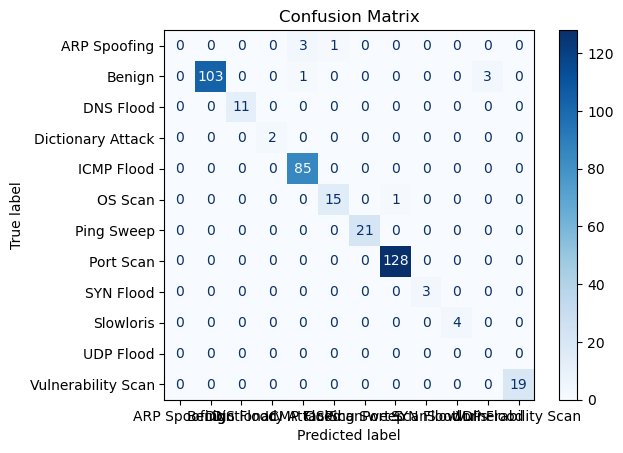

In [16]:
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Read data from a text file
with open("classification_results.txt", "r") as file:
    data = file.read()

# Step 2: Extract all unique true labels
true_labels_set = set()
true_labels = []
predicted_labels = []


# Regular expression to extract the true label and predicted label
pattern = r"True Label: (.*?), Predicted Label: (.*)"

# Extract and gather all unique true labels
for line in data.strip().split('\n'):
    match = re.search(pattern, line)
    if match:
        true_label = match.group(1).strip()
        # Add to the set of true labels
        true_labels_set.add(true_label)

true_labels_set.add("UDP Flood")
# Extract and gather all unique true labels
for line in data.strip().split('\n'):
    match = re.search(pattern, line)
    if match:
        predicted_label = match.group(2).strip()
        true_label = match.group(1).strip()
        # Check if the predicted label is in the set of true labels
        flag = 0
        for label in true_labels_set:
            if predicted_label in label:
                predicted_labels.append(label)
                flag = 1
        if flag == 1:
            true_labels.append(true_label)
        else:
            print(line)


print(len(predicted_labels))
# Convert to numpy arrays for compatibility with sklearn
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Step 3: Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=np.unique(list(true_labels_set)))

# Step 4: Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(list(true_labels_set)))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")  # Save the figure
plt.show()
